# Nightshade: Prompt-Specific Poisoning Attack Implementation
## Poison Dataset Generation for Text-to-Image Models
Based on: *"Nightshade: Prompt-Specific Poisoning Attacks on Text-to-Image Generative Models"*  
Shan et al., University of Chicago, 2024

**Goal**: Generate stealthy poison images that corrupt diffusion model training with minimal samples (<100)


| Parameter | Value | Description |
|-----------|-------|-------------|
| **Target Concept (C)** | `cat` | Prompt to corrupt |
| **Destination Concept (A)** | `dog` | Desired output |
| **LPIPS Budget** | `0.07` | Max visual perturbation |
| **Dataset Size** | `25` samples | Poison samples to generate |
| **Image Size** | `512×512` | Model input dimensions |

In [ ]:
!git clone https://github.com/Shawn-Shan/nightshade-release.git
%cd nightshade-release
!ls -la

In [ ]:
!pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install -q diffusers transformers accelerate
!pip install -q pillow numpy tqdm einops
!pip install -q scikit-learn
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q lpips

In [3]:
import os

BASE_DIR = "/kaggle/working/nightshade_data"
os.makedirs(f"{BASE_DIR}/source_images", exist_ok=True)  # my cat images
os.makedirs(f"{BASE_DIR}/selected", exist_ok=True)       # selected by data_extraction.py
os.makedirs(f"{BASE_DIR}/poison_output", exist_ok=True)  # final poison

print(f"Created: {BASE_DIR}")
print("Upload cat images to: nightshade_data/source_images/")

Created: /kaggle/working/nightshade_data
Upload cat images to: nightshade_data/source_images/


In [ ]:
import os
import glob
import random
import pickle
import numpy as np
from PIL import Image

BASE_DIR = "/kaggle/working/nightshade_data"
CAT_PATH = "/kaggle/input/datasets/tongpython/cat-and-dog/training_set/training_set/cats/"

cat_files = glob.glob(os.path.join(CAT_PATH, "*.jpg"))
print(f"Found {len(cat_files)} cat images")

k = min(50, len(cat_files))
random.seed(42)
selected = random.sample(cat_files, k)


SAVE_PATH = f"{BASE_DIR}/source_images"
os.makedirs(SAVE_PATH, exist_ok=True)

for i, img_path in enumerate(selected):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((512, 512), Image.Resampling.LANCZOS)
    
    data = {
        "img": np.array(img),
        "text": "a photo of a cat",
    }
    
    with open(f"{SAVE_PATH}/{i}.p", "wb") as f:
        pickle.dump(data, f)
    
    print(f" Saved {i}.p → selected/: {os.path.basename(img_path)}")

In [11]:
!python data_extraction.py \
    -d /kaggle/working/nightshade_data/source_images \
    -od /kaggle/working/nightshade_data/selected \
    -n 25 \
    -c cat

print("\n Selected images:")
!ls -la /kaggle/working/nightshade_data/selected/


 Selected images:
total 19308
drwxr-xr-x 2 root root   4096 Feb 25 20:15 .
drwxr-xr-x 5 root root   4096 Feb 25 20:09 ..
-rw-r--r-- 1 root root 786634 Feb 25 20:15 0.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 10.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 11.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 12.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 13.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 14.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 15.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 16.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 17.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 18.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 19.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 1.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 20.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 21.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 22.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 23.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 24.p
-rw-r--r-- 1 root root 786634 Feb 25 20:15 2.p
-rw-r--r-- 1 root

Found 25 images to display


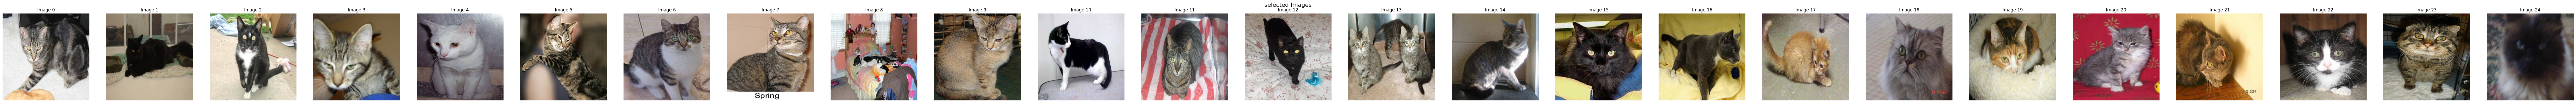

In [12]:
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image

BASE_DIR = "/kaggle/working/nightshade_data"
DATA_PATH = f"{BASE_DIR}/selected"  
files = sorted(os.listdir(DATA_PATH))
n = len(files)

print(f"Found {n} images to display")

fig, axes = plt.subplots(1, n, figsize=(4*n, 4))

if n == 1:
    axes = [axes]

for i, file in enumerate(files):
    with open(os.path.join(DATA_PATH, file), "rb") as f:
        data = pickle.load(f)
    
    img = Image.fromarray(data["img"])
    axes[i].imshow(img)
    axes[i].set_title(f"Image {i}")
    axes[i].axis('off')

plt.suptitle("selected Images", fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
OPT_PATH = "/kaggle/working/nightshade-release/opt.py"

with open(OPT_PATH, "r") as f:
    content = f.read()

# Replace model
content = content.replace(
    "stabilityai/stable-diffusion-2-1",
    "sd2-community/stable-diffusion-2-1"
)

content = content.replace(
    'revision="fp16",',
    ""
)

# Write back
with open(OPT_PATH, "w") as f:
    f.write(content)

print("\nCurrent from_pretrained call:")
!grep -A 5 -B 2 "from_pretrained" {OPT_PATH}


Current from_pretrained call:

    def load_model(self):
        pipeline = StableDiffusionPipeline.from_pretrained(
            "sd2-community/stable-diffusion-2-1",
            safety_checker=None,
            
            torch_dtype=torch.float16,
        )


In [14]:
# Search all python files for the old model name
!grep -r "stabilityai/stable-diffusion-2-1" /kaggle/working/nightshade-release/

In [15]:
!python gen_poison.py \
    -d /kaggle/working/nightshade_data/selected \
    -od /kaggle/working/nightshade_data/poison_output \
    -t dog 

print("\n Generated poison:")
!ls -la /kaggle/working/nightshade_data/poison_output/

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Fetching 13 files: 100%|████████████████████████| 13/13 [00:14<00:00,  1.14s/it]
Download complete: : 5.16GB [00:14, 969MB/s]                                    
Download complete: : 5.16GB [00:14, 347MB/s]              | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:  33%|████▎        | 2/6 [00:02<00:04,  1.03s/it]
Loading weights: 100%|█| 372/372 [00:00<00:00, 678.46it/s, Materializing param=t
CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--sd2-community--stable-diffusion-2-1/snapshots/bb2154823665391b4fb29b0b9cf82a198964ee05/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddin

Text: a photo of a cat


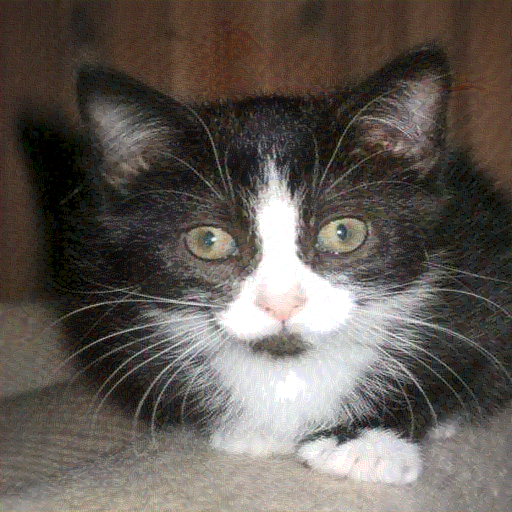

In [16]:
import pickle
import torch
import clip

with open("/kaggle/working/nightshade_data/poison_output/0.p", "rb") as f:
    data = pickle.load(f)

img = data['img'] 
print("Text:", data['text'])
img 

In [17]:
device = "cuda"
model, preprocess = clip.load("ViT-B/32", device=device)

image_tensor = preprocess(img).unsqueeze(0).to(device)
labels = ["a photo of a cat", "a photo of a dog"]
text = clip.tokenize(labels).to(device)

with torch.no_grad():
    img_feat = model.encode_image(image_tensor)
    txt_feat = model.encode_text(text)
    img_feat /= img_feat.norm(dim=-1, keepdim=True)
    txt_feat /= txt_feat.norm(dim=-1, keepdim=True)
    sim = (100.0 * img_feat @ txt_feat.T).softmax(dim=-1)

print(f"Cat: {sim[0][0].item():.2%}")
print(f"Dog: {sim[0][1].item():.2%}")

Cat: 99.61%
Dog: 0.41%


In [18]:
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("sd2-community/stable-diffusion-2-1")

# encode with VAE
import torch
import numpy as np
from PIL import Image

img_tensor = torch.tensor(np.array(img)).permute(2,0,1).unsqueeze(0).float() / 255.0
img_tensor = (img_tensor - 0.5) / 0.5  # normalize to [-1, 1]

with torch.no_grad():
    latent = pipe.vae.encode(img_tensor).latent_dist.mean
    print("Latent shape:", latent.shape)

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--sd2-community--stable-diffusion-2-1/snapshots/bb2154823665391b4fb29b0b9cf82a198964ee05/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Latent shape: torch.Size([1, 4, 64, 64])


In [20]:
import os
import pickle
import torch
import numpy as np
from PIL import Image
from diffusers import StableDiffusionPipeline

# 1. Load ALL 25 poisoned images
poison_dir = "/kaggle/working/nightshade_data/poison_output/"
poisoned_imgs = []

for i in range(25):
    path = os.path.join(poison_dir, f"{i}.p")
    if os.path.exists(path):
        with open(path, "rb") as f:
            data = pickle.load(f)
        poisoned_imgs.append(data['img'])
        print(f"Loaded poison {i} | prompt: {data['text']}")

print(f"\nTotal poisoned images loaded: {len(poisoned_imgs)}")

# 2. Load pipeline
pipe = StableDiffusionPipeline.from_pretrained("sd2-community/stable-diffusion-2-1")
pipe.vae.eval()

# 3. get_latent function
def get_latent(img, pipe):
    img_tensor = torch.tensor(np.array(img)).permute(2,0,1).unsqueeze(0).float() / 255.0
    img_tensor = (img_tensor - 0.5) / 0.5
    with torch.no_grad():
        latent = pipe.vae.encode(img_tensor).latent_dist.mean
    return latent

# 4. get_avg_latent from folder
def get_avg_latent_folder(folder, pipe, n=25):
    latents = []
    files = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))][:n]
    print(f"Found {len(files)} files in {folder}")
    for f in files:
        try:
            img = Image.open(os.path.join(folder, f)).convert("RGB").resize((512, 512))
            latents.append(get_latent(img, pipe))
        except Exception as e:
            print(f"Failed {f}: {e}")
    if len(latents) == 0:
        raise ValueError(f"No images loaded from {folder}")
    return torch.stack(latents).mean(dim=0)

# 5. get_avg_latent from poisoned list
def get_avg_latent_list(img_list, pipe):
    latents = []
    for img in img_list:
        try:
            latents.append(get_latent(img, pipe))
        except Exception as e:
            print(f"Failed: {e}")
    if len(latents) == 0:
        raise ValueError("No poisoned images encoded")
    return torch.stack(latents).mean(dim=0)

# 6. Compute all latents
cat_dir = "/kaggle/input/datasets/tongpython/cat-and-dog/training_set/training_set/cats/"
dog_dir = "/kaggle/input/datasets/tongpython/cat-and-dog/training_set/training_set/dogs/"

print("\nEncoding 25 poisoned images...")
avg_poisoned_latent = get_avg_latent_list(poisoned_imgs, pipe)

print("\nEncoding 25 clean cat images...")
avg_cat_latent = get_avg_latent_folder(cat_dir, pipe, n=25)

print("\nEncoding 25 clean dog images...")
avg_dog_latent = get_avg_latent_folder(dog_dir, pipe, n=25)

# 7. Compare distances
dist_to_cat = torch.nn.functional.mse_loss(avg_poisoned_latent, avg_cat_latent)
dist_to_dog = torch.nn.functional.mse_loss(avg_poisoned_latent, avg_dog_latent)

gap = dist_to_cat.item() - dist_to_dog.item()
shift = (gap / dist_to_cat.item()) * 100

print(f"\nAvg Poisoned vs Avg CAT distance: {dist_to_cat.item():.4f}")
print(f"Avg Poisoned vs Avg DOG distance: {dist_to_dog.item():.4f}")
print(f"Feature shift:                    {gap:.4f}")
print(f"Shift percentage:                 {shift:.1f}%")

if dist_to_dog < dist_to_cat:
    print("\nPoison WORKED - 25 poisoned cat images shifted toward dog in feature space!")
else:
    print("\nPoison did not shift features - check poison generation")

Loaded poison 0 | prompt: a photo of a cat
Loaded poison 1 | prompt: a photo of a cat
Loaded poison 2 | prompt: a photo of a cat
Loaded poison 3 | prompt: a photo of a cat
Loaded poison 4 | prompt: a photo of a cat
Loaded poison 5 | prompt: a photo of a cat
Loaded poison 6 | prompt: a photo of a cat
Loaded poison 7 | prompt: a photo of a cat
Loaded poison 8 | prompt: a photo of a cat
Loaded poison 9 | prompt: a photo of a cat
Loaded poison 10 | prompt: a photo of a cat
Loaded poison 11 | prompt: a photo of a cat
Loaded poison 12 | prompt: a photo of a cat
Loaded poison 13 | prompt: a photo of a cat
Loaded poison 14 | prompt: a photo of a cat
Loaded poison 15 | prompt: a photo of a cat
Loaded poison 16 | prompt: a photo of a cat
Loaded poison 17 | prompt: a photo of a cat
Loaded poison 18 | prompt: a photo of a cat
Loaded poison 19 | prompt: a photo of a cat
Loaded poison 20 | prompt: a photo of a cat
Loaded poison 21 | prompt: a photo of a cat
Loaded poison 22 | prompt: a photo of a ca

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--sd2-community--stable-diffusion-2-1/snapshots/bb2154823665391b4fb29b0b9cf82a198964ee05/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Encoding 25 poisoned images...

Encoding 25 clean cat images...
Found 25 files in /kaggle/input/datasets/tongpython/cat-and-dog/training_set/training_set/cats/

Encoding 25 clean dog images...
Found 25 files in /kaggle/input/datasets/tongpython/cat-and-dog/training_set/training_set/dogs/

Avg Poisoned vs Avg CAT distance: 8.0080
Avg Poisoned vs Avg DOG distance: 6.5329
Feature shift:                    1.4751
Shift percentage:                 18.4%

Poison WORKED - 25 poisoned cat images shifted toward dog in feature space!


In [ ]:
import os
import pickle
import shutil
from PIL import Image
import numpy as np

BASE_DIR = "/kaggle/working/nightshade_data"
poison_dir = f"{BASE_DIR}/poison_output"
selected_dir = f"{BASE_DIR}/source_images" 

# Create download folders
download_dir = f"{BASE_DIR}/downloads"
os.makedirs(f"{download_dir}/poisoned_pkl", exist_ok=True)
os.makedirs(f"{download_dir}/poisoned_jpg", exist_ok=True)
os.makedirs(f"{download_dir}/selected_jpg", exist_ok=True)

# Poisoned images - save as both pkl and jpg
print("Processing poisoned images...")
poison_files = [f for f in os.listdir(poison_dir) if f.endswith('.p')]
print(f"Found {len(poison_files)} poisoned images")

for fname in poison_files:
    src_path = os.path.join(poison_dir, fname)
    shutil.copy(src_path, f"{download_dir}/poisoned_pkl/{fname}")
    
    with open(src_path, "rb") as f:
        data = pickle.load(f)
    
    img = data['img']  # already PIL from nightshade output
    jpg_name = fname.replace('.p', '.jpg')
    img.save(f"{download_dir}/poisoned_jpg/{jpg_name}")
    print(f"  Saved {fname} as pkl and jpg")

# Selected/source images - jpg only
print("\nProcessing source images...")
source_files = [f for f in os.listdir(selected_dir) if f.endswith('.p')]
print(f"Found {len(source_files)} source images")

for fname in source_files:
    src_path = os.path.join(selected_dir, fname)
    
    with open(src_path, "rb") as f:
        data = pickle.load(f)
    
    # Your source pickles store img as numpy array
    if isinstance(data['img'], np.ndarray):
        img = Image.fromarray(data['img'].astype(np.uint8))
    else:
        img = data['img']  # already PIL
    
    jpg_name = fname.replace('.p', '.jpg')
    img.save(f"{download_dir}/selected_jpg/{jpg_name}")
    print(f"  Saved {fname} as jpg")


print("\nZipping all downloads...")
shutil.make_archive(f"{BASE_DIR}/nightshade_results", 'zip', download_dir)
print(f"Done! Download: {BASE_DIR}/nightshade_results.zip")

## References

```bibtex
@article{shan2024nightshade,
  title={Nightshade: Prompt-Specific Poisoning Attacks on Text-to-Image Generative Models},
  author={Shan, Shawn and Ding, Wenxin and Passananti, Josephine and Wu, Stanley and Zheng, Haitao and Zhao, Ben Y},
  journal={IEEE S\&P},
  year={2024}
}
```

- Paper: https://arxiv.org/abs/2310.13828
- Github: https://github.com/Shawn-Shan/nightshade-release
- Project: https://nightshade.cs.uchicago.edu/